# Imports

In [4]:
from datasets import load_dataset, load_from_disk
from collections import Counter
import functools

In [5]:
%run PII_Util.py

# Initialize Model Adapter

In [6]:
model_adapter = Yanis_Adapter(threshold = 0.1, checkpoint_path='./fine_tuned/yanis/yanis_01', config_only=True)

# Data

In [7]:
%%time
# preprocessed_dataset = load_from_disk("./in/tokenized_datasets")
preprocessed_dataset = load_from_disk("./in/preprocessed_dataset_2")

CPU times: total: 62.5 ms
Wall time: 1.65 s


In [8]:
%%time
loaded_predictions = np.load("./in/preds02.npy")

CPU times: total: 359 ms
Wall time: 356 ms


# Postprocessing

In [9]:
%%time
list_word_ids = [[word_id if word_id is not None else -100 for word_id in word_ids] for word_ids in preprocessed_dataset['word_ids'] ]
word_ids_padded = pad_lists(list_word_ids, -100,  loaded_predictions.shape[1])
labels_padded = pad_lists(preprocessed_dataset['labels'], -100, loaded_predictions.shape[1])
threshold = 0.01

CPU times: total: 8.22 s
Wall time: 8.21 s


In [10]:
threshold = 0.01

In [24]:
%%time


#Positive class thresholding
def get_tokens_thresholding(np_probs, true_labels_id, threshold, model_adapter):
    
#     np_probs = loaded_predictions
#     true_labels_id = labels_padded
#     threshold = 0.01
    
    # --- Initialize variables
    label2id =  model_adapter.config.label2id
    o_index = label2id['O']

    # --- Get indices of highest probabilities
    np_sorted_indices = np.argsort(np_probs)
    np_max_indices = np_sorted_indices[:,:, -1]
    # np_max = np_sorted_indices[np.arange(np_max_indices.shape[0]), np_max_indices]
    np_max_prob = np.take_along_axis(np_probs, np_max_indices[:, :, np.newaxis], axis=2).squeeze()

    
    # --- Get 2nd max probabilities
    np_2nd_max_indices = np_sorted_indices[:, :, -2]
    # np_2nd_max = np_sorted_indices[np.arange(np_sorted_indices.shape[0]), np_max_indices]
    np_2nd_max_prob = np.take_along_axis(np_probs, np_2nd_max_indices[:, :, np.newaxis], axis=2).squeeze()

        
    del np_probs
    # --- Conditional replace (Positive label thresholding)
    
    #Masks
    np_O_mask = np_max_indices == o_index
    np_threshold_mask = np_2nd_max_prob > threshold
    np_replace_mask = np_threshold_mask & np_O_mask

    #Replace
    np_label_ids = np.where(np_replace_mask, np_2nd_max_indices, np_max_indices)

    # Postprocess labels, convert irrelevant labels to 'O'
    if getattr(model_adapter, 'labels_irrelevant', None):
        np_labels_irrelevant = np.array(model_adapter.labels_irrelevant)
        label_ids_mask = np.isin(np_label_ids, np_labels_irrelevant)
        np_label_ids[label_ids_mask] = o_index

    # Flatten token(subwords) for metrics
    flat_label_ids = np_label_ids.flatten()
    flat_true_labels_id = true_labels_id.flatten()

    # Remove padding preds for metrics
    mask_padding_inv = flat_true_labels_id != -100
    flat_true_labels_id = flat_true_labels_id[mask_padding_inv]
    flat_label_ids = flat_label_ids[mask_padding_inv]
    
    return np_label_ids, flat_true_labels_id, flat_label_ids

# np_label_ids, flat_true_labels_id, flat_label_ids = get_tokens_thresholding(loaded_predictions, labels_padded, threshold, model_adapter)


CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
del loaded_predictions

In [1]:
%%time

#Word-token alignment
def get_word_preds(np_pred_tokens, word_ids_padded, model_adapter):
    row_size = word_ids_padded.shape[1]
    diff_array = np.diff(word_ids_padded[:,:], axis=1, append=row_size)

    #Calculate row boundaries
    non_zero = np.where(diff_array != 0, 1, 0)
    group_ids = np.cumsum(non_zero, axis=1) 
    row_boundaries = np.cumsum(group_ids.max(axis = 1))

    #Calculate splits, split into groups, Truncate > 10
    split_indices =  np.where(diff_array.ravel() != 0)[0] + 1 # Orig
    list_groups = np.split(np_pred_tokens[:,:].ravel(), split_indices)
    list_groups = [group[:10] if len(group) >= 10 else group for group in list_groups]

    #30s Calculate modes per group
    word_labels = [Counter(arr.tolist()).most_common(1)[0][0] if len(arr) > 0 else None for arr in list_groups]

    #Fast (split into rows)
    np_word_labels = np.array(word_labels)
    list_pred_incomp = np.split(np_word_labels, row_boundaries)

    #10s Initialize row arrays for word-level predictions
    list_pred_words = [np.full((len(words)), model_adapter.O_id, dtype='int8') for words in preprocessed_dataset['words']]

    #5s Get word_indices not skipped in word_ids (Handles CLS and Padding tokens)
    list_word_indices = []
    for word_ids in preprocessed_dataset['word_ids']:
        indices = set(word_ids)
        indices.discard(None)
        list_word_indices.append(np.array(list(indices)))

    #200ms Align the processed word-level predictions to initialized array
    for pred_words, word_indices, pred_incomp in zip(list_pred_words, list_word_indices, list_pred_incomp):
        pred_words[word_indices] = pred_incomp[1:-1]
        
    return list_pred_words

# list_pred_words = get_word_preds(np_label_ids, word_ids_padded, model_adapter)

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
def to_bio_vect(np_pred_words, np_model_id2cur_entity_id = np_class_id2entity_id):
#     global cumsum, out, zeros, change_indices, accumulate, diff_array, b_mask_indices, i_mask_indices, b_words, i_words, b_words_mapped, i_words_mapped
    
    np_pred_words = np_model_id2cur_entity_id[np_pred_words]
    
    row_size = np_pred_words.shape[0]
    diff_array = np.diff(np_pred_words, axis=0, prepend=-1)
    change_indices = np.where(diff_array!=0, 0, 1)
    zeros = change_indices == 0 #reverse of change_indices
    cumsum = np.cumsum(change_indices, axis=0)
    accumulate = np.maximum.accumulate(np.where(zeros, cumsum, 0), axis=0)
    out = cumsum - accumulate
    b_mask = out == 0
    b_mask_indices = np.where(b_mask)
    i_mask_indices = np.where(~b_mask)
    
    np_pred_words_mapped = np.empty_like(np_pred_words)
    
    b_words = np_pred_words[b_mask_indices]
    i_words = np_pred_words[i_mask_indices]
    
    b_words_mapped = np_entity_id2class_id_b[b_words]
    i_words_mapped = np_entity_id2class_id_i[i_words]
    
    np_pred_words_mapped[b_mask_indices] = b_words_mapped
    np_pred_words_mapped[i_mask_indices] = i_words_mapped
    
    return np_pred_words_mapped



# Metrics optimized

In [14]:
import numpy as np

def count_confusion_matrix(predictions, labels, num_classes):
    """
    Count confusion matrix per class ID.
    
    Args:
    - predictions: NumPy array of predicted class labels (shape: [N]).
    - labels: NumPy array of ground truth class labels (shape: [N]).
    - num_classes: Number of classes.
    
    Returns:
    - TP: NumPy array of True Positives per class ID.
    - TN: NumPy array of True Negatives per class ID.
    - FN: NumPy array of False Negatives per class ID.
    - FP: NumPy array of False Positives per class ID.
    """
    
    global confusion_matrix
    
    
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    np.add.at(confusion_matrix, (labels, predictions), 1)
    
    # True Positives (TP)
    TP = np.diag(confusion_matrix)
    
    # True Negatives (TN)
    TN = np.sum(confusion_matrix) - np.sum(confusion_matrix[np.eye(num_classes, dtype=bool)])
    
    # False Negatives (FN)
    FN = np.sum(confusion_matrix, axis=1) - TP
    
    # False Positives (FP)
    FP = np.sum(confusion_matrix, axis=0) - TP
    
    return confusion_matrix, TP, TN, FN, FP

# Example usage:
predictions = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
labels = np.array([0, 1, 2, 1, 2, 0, 1, 2, 0])
num_classes = 3

confusion_matrix, TP, TN, FN, FP = count_confusion_matrix(predictions, labels, num_classes)
print("True Positives per class:", TP)
print("True Negatives per class:", TN)
print("False Negatives per class:", FN)
print("False Positives per class:", FP)

True Positives per class: [1 1 1]
True Negatives per class: 6
False Negatives per class: [2 2 2]
False Positives per class: [2 2 2]


In [ ]:
flat_true_labels_id, flat_label_ids

In [15]:
%%time

confusion_matrix, TP, TN, FN, FP = count_confusion_matrix(predictions = flat_label_ids, labels = flat_true_labels_id, num_classes = len(classes))

NameError: name 'flat_label_ids' is not defined

## V2

In [16]:
def compute_metrics_per_class(TP, FN, FP, class_label, beta=5):
    
    tp = TP[class_label]
    fn = FN[class_label]
    fp = FP[class_label]
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0 
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if precision + recall > 0 else 0
    
    metrics = {'precision':precision, 'recall':recall, 'f_beta':f_beta,'tp':tp, 'fp':fp, 'fn':fn}
    
    return metrics

In [17]:
def compute_micro_metrics(predictions, labels, num_classes, pos_labels, prefix='', beta=5):
#     global class_metrics
    
    
    confusion_matrix, TP, TN, FN, FP = count_confusion_matrix(predictions = predictions, labels = labels, num_classes = len(classes))
    
    class_metrics = {f'{prefix}{class_label}':compute_metrics_per_class(TP, FN, FP, class_label, beta=beta) for class_label in range(num_classes)}
#     class_metrics = {key:value for class_label in range(num_classes) for key,value in compute_metrics_per_class(TP, FN, FP, class_label, beta=beta, prefix=prefix).items()}
    
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    total_metrics = {'precision':total_precision, 'recall':total_recall, 'f_beta':total_f_beta,'tp':total_tp, 'fp':total_fp, 'fn':total_fn}
    
    
    return total_metrics, class_metrics, confusion_matrix


### Token level

In [62]:
%%time
total_metrics, class_metrics, confusion_matrix = compute_micro_metrics(predictions = flat_label_ids, labels = flat_true_labels_id, num_classes = len(classes), pos_labels=classes_pos_id, beta=5)

CPU times: total: 156 ms
Wall time: 136 ms


In [64]:
total_metrics

{'precision': 0.3438857852265674,
 'recall': 0.6655225673588467,
 'f_beta': 0.6424129670217645,
 'tp': 3878,
 'fp': 7399,
 'fn': 1949}

In [69]:
df_class_metrics = pd.DataFrame(class_metrics)
df_class_metrics.columns = df_class_metrics.columns.map(id2classes)
df_class_metrics

,O,B-EMAIL,B-ID_NUM,B-NAME_STUDENT,B-PHONE_NUM,B-STREET_ADDRESS,B-URL_PERSONAL,B-USERNAME,I-ID_NUM,I-NAME_STUDENT,I-PHONE_NUM,I-STREET_ADDRESS,I-URL_PERSONAL
precision,9.996945e-01,0.0,0.703008,0.323795,0.0,0.0,0.365321,0.0,0.0,0.329795,0.0,0.0,0.0
recall,9.985433e-01,0.0,0.502688,0.838879,0.0,0.0,0.464155,0.0,0.0,0.933743,0.0,0.0,0.0
f_beta,9.985875e-01,0.0,0.508258,0.790513,0.0,0.0,0.459375,0.0,0.0,0.872303,0.0,0.0,0.0
tp,4.725634e+06,0.0,187.000000,1437.000000,0.0,0.0,887.000000,0.0,0.0,1367.000000,0.0,0.0,0.0
fp,1.444000e+03,0.0,79.000000,3001.000000,0.0,0.0,1541.000000,0.0,0.0,2778.000000,0.0,0.0,0.0
fn,6.894000e+03,263.0,185.000000,276.000000,11.0,2.0,1024.000000,20.0,3.0,97.000000,39.0,22.0,7.0


In [122]:
df_class_metrics.T

,precision,recall,f_beta,tp,fp,fn
O,0.999695,0.998543,0.998588,4725634.0,1444.0,6894.0
B-EMAIL,0.000000,0.000000,0.000000,0.0,0.0,263.0
B-ID_NUM,0.703008,0.502688,0.508258,187.0,79.0,185.0
B-NAME_STUDENT,0.323795,0.838879,0.790513,1437.0,3001.0,276.0
B-PHONE_NUM,0.000000,0.000000,0.000000,0.0,0.0,11.0
B-STREET_ADDRESS,0.000000,0.000000,0.000000,0.0,0.0,2.0
B-URL_PERSONAL,0.365321,0.464155,0.459375,887.0,1541.0,1024.0
B-USERNAME,0.000000,0.000000,0.000000,0.0,0.0,20.0
I-ID_NUM,0.000000,0.000000,0.000000,0.0,0.0,3.0
I-NAME_STUDENT,0.329795,0.933743,0.872303,1367.0,2778.0,97.0


### Word Level

In [63]:
%%time

total_metrics_w, class_metrics_w, confusion_matrix_w = compute_micro_metrics(predictions = flat_word_label_ids, labels = flat_word_true_labels_id, num_classes = len(classes), pos_labels=classes_pos_id, beta=5)

CPU times: total: 125 ms
Wall time: 150 ms


In [65]:
total_metrics_w

{'precision': 0.3433709147994862,
 'recall': 0.8784227820372399,
 'f_beta': 0.8287538750960493,
 'tp': 2406,
 'fp': 4601,
 'fn': 333}

In [70]:
df_class_metrics_w = pd.DataFrame(class_metrics_w)
df_class_metrics_w.columns = df_class_metrics_w.columns.map(id2classes)
df_class_metrics_w

,O,B-EMAIL,B-ID_NUM,B-NAME_STUDENT,B-PHONE_NUM,B-STREET_ADDRESS,B-URL_PERSONAL,B-USERNAME,I-ID_NUM,I-NAME_STUDENT,I-PHONE_NUM,I-STREET_ADDRESS,I-URL_PERSONAL
precision,9.999480e-01,0.0,0.795918,0.294456,0.0,0.0,0.374302,0.0,0.0,0.422360,0.0,0.0,0.0
recall,9.990927e-01,0.0,0.500000,0.937729,0.0,0.0,0.609091,0.0,0.0,0.930657,0.0,0.0,0.0
f_beta,9.991256e-01,0.0,0.507254,0.865045,0.0,0.0,0.594742,0.0,0.0,0.889485,0.0,0.0,0.0
tp,4.985267e+06,0.0,39.000000,1280.000000,0.0,0.0,67.000000,0.0,0.0,1020.000000,0.0,0.0,0.0
fp,2.590000e+02,0.0,10.000000,3067.000000,0.0,0.0,112.000000,0.0,17.0,1395.000000,0.0,0.0,0.0
fn,4.527000e+03,39.0,39.000000,85.000000,6.0,2.0,43.000000,6.0,1.0,76.000000,15.0,20.0,1.0


## Old Version

In [46]:
from datasets import load_metric

In [47]:
METRIC_F1 = load_metric("f1",  beta=5)
METRIC_PRECISION = load_metric("precision")
METRIC_RECALL = load_metric("recall")

C:\Users\cloud\AppData\Local\Temp\ipykernel_14128\3877367123.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  METRIC_F1 = load_metric("f1",  beta=5)
D:\Anaconda3\envs\nlp_torch\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
D:\Anaconda3\envs\nlp_torch\Lib\site-packages\datasets\load.py:753: FutureWarning: The repository for precision contains custom code which must be executed to correctly load t

In [50]:
classes_pos_id

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### token level

In [51]:
%%time

f1_score = METRIC_F1.compute(predictions=flat_label_ids, references=flat_true_labels_id, labels=classes_pos_id, average ='micro')
f_beta_score = fbeta_score(y_pred = flat_label_ids ,y_true = flat_true_labels_id, labels = classes_pos_id,beta=5, average='micro')
precision = METRIC_PRECISION.compute(predictions=flat_label_ids, references=flat_true_labels_id,labels=classes_pos_id, average ='micro')
recall = METRIC_RECALL.compute(predictions=flat_label_ids, references=flat_true_labels_id,labels=classes_pos_id, average ='micro')


dict_scores = {}

for score in [f1_score, precision, recall]:
    dict_scores.update(score) 
    
dict_scores['f_beta'] = f_beta_score

NameError: name 'dict_scores' is not defined

In [59]:
dict_scores

{'f1': 0.45346117867165575,
 'precision': 0.3438857852265674,
 'recall': 0.6655225673588467,
 'f_beta': 0.6424129670217646}

### word level

In [54]:
%%time

cur_preds = flat_word_label_ids
cur_true = flat_word_true_labels_id
pos_labels = classes_pos_id

# predictions=cur_preds, references=cur_true
# y_pred=cur_preds, y_true=cur_true
f1_score = METRIC_F1.compute(predictions=cur_preds, references=cur_true, labels=pos_labels, average ='micro')
f_beta_score = fbeta_score(y_pred=cur_preds, y_true=cur_true, labels = pos_labels,beta=5, average='micro')
precision = METRIC_PRECISION.compute(predictions=cur_preds, references=cur_true,labels=pos_labels, average ='micro')
recall = METRIC_RECALL.compute(predictions=cur_preds, references=cur_true,labels=pos_labels, average ='micro')

dict_scores_word = {}
for score in [f1_score, precision, recall]:
    k,v = list(score.items())[0]
    dict_scores_word[f'word_{k}'] = v

dict_scores_word['word_f_beta'] = word_f_beta

NameError: name 'word_precision' is not defined

In [57]:
dict_scores_word = {}
for score in [f1_score, precision, recall]:
    k,v = list(score.items())[0]
    dict_scores_word[f'word_{k}'] = v

dict_scores_word['word_f_beta'] = f_beta_score

In [60]:
dict_scores_word

{'word_f1': 0.49374102195772623,
 'word_precision': 0.3433709147994862,
 'word_recall': 0.8784227820372399,
 'word_f_beta': 0.8287538750960494}

# compute_metrics

In [2]:
def compute_metrics_base(eval_preds, preprocessed_dataset, model_adapter, threshold = 0.1):

    np_probs, true_labels_id, inputs = eval_preds
    
    #---- Token Preds
    np_label_ids, flat_true_labels_id, flat_label_ids = get_tokens_thresholding(loaded_predictions, true_labels_id, threshold, model_adapter)

    #---- Word Preds

    list_word_ids = [[word_id if word_id is not None else -100 for word_id in word_ids] for word_ids in preprocessed_dataset['word_ids'] ]
    word_ids_padded = pad_lists(list_word_ids, -100,  loaded_predictions.shape[1])
    
    list_pred_words = get_word_preds(np_label_ids, word_ids_padded, model_adapter)
    
    
    list_pred_words_mapped = [to_bio_vect(pred_words, np_class_id2entity_id) for pred_words in list_pred_words]
    flat_word_label_ids = np.concatenate(list_pred_words_mapped)
    
    list_word_true_labels = preprocessed_dataset['word_labels']
    
    flat_word_true_labels_id = np.array([classes2id[word] for list_words in list_word_true_labels for word in list_words], dtype='int8')
    
 
    total_metrics, class_metrics, confusion_matrix = compute_micro_metrics(predictions = flat_label_ids, labels = flat_true_labels_id, 
                                                                           num_classes = len(classes), pos_labels=classes_pos_id, beta=5, prefix='token_')
    
    total_metrics_w, class_metrics_w, confusion_matrix_w = compute_micro_metrics(predictions = flat_word_label_ids, labels = flat_word_true_labels_id, 
                                                                                 num_classes = len(classes), pos_labels=classes_pos_id, beta=5, prefix='word_')
    
    dict_scores = {'token_confusion_matrix' : confusion_matrix,
                  'word_confusion_matrix' : confusion_matrix_w,
                   'token_total_metrics' : total_metrics,
                   'word_total_metrics' : total_metrics_w}
    
    dict_scores.update(class_metrics)
    dict_scores.update(class_metrics_w)
    
    return dict_scores
    
    

In [27]:
compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=preprocessed_dataset, model_adapter=model_adapter, threshold=0.01)

In [36]:
def col_id2label(col_name):
    list_name = col_name.split('_')
    
    if list_name[-1].isdigit():
        label_id = int(list_name[-1])
        list_name[-1] = id2classes[label_id]
        
        return '_'.join(list_name)
        
    else:
        return col_name

In [20]:
loaded_predictions = np.load("./in/preds02.npy")

In [28]:
%%time
eval_preds = (loaded_predictions, labels_padded, None)
dict_all_scores = compute_metrics(eval_preds)

CPU times: total: 1min 2s
Wall time: 1min 2s


In [29]:
token_confusion_matrix = dict_all_scores.pop('token_confusion_matrix')
word_confusion_matrix = dict_all_scores.pop('word_confusion_matrix')

In [38]:
%%time
df_all_metrics = pd.DataFrame(dict_all_scores)
df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
df_all_metrics = df_all_metrics.T
df_all_metrics

CPU times: total: 0 ns
Wall time: 3 ms


,precision,recall,f_beta,tp,fp,fn
token_total_metrics,0.343886,0.665523,0.642413,3878.0,7399.0,1949.0
word_total_metrics,0.343371,0.878423,0.828754,2406.0,4601.0,333.0
token_O,0.999695,0.998543,0.998588,4725634.0,1444.0,6894.0
token_B-EMAIL,0.000000,0.000000,0.000000,0.0,0.0,263.0
token_B-ID_NUM,0.703008,0.502688,0.508258,187.0,79.0,185.0
token_B-NAME_STUDENT,0.323795,0.838879,0.790513,1437.0,3001.0,276.0
token_B-PHONE_NUM,0.000000,0.000000,0.000000,0.0,0.0,11.0
token_B-STREET_ADDRESS,0.000000,0.000000,0.000000,0.0,0.0,2.0
token_B-URL_PERSONAL,0.365321,0.464155,0.459375,887.0,1541.0,1024.0
token_B-USERNAME,0.000000,0.000000,0.000000,0.0,0.0,20.0


## Persist

In [39]:
np.savez('./results/conf_matrices_1.npz', token_confusion_matrix=token_confusion_matrix,word_confusion_matrix=word_confusion_matrix)
df_all_metrics.to_csv('./results/all_metrics_1.csv', index=False)

In [52]:
# npz_conf_matrices =  np.load('./results/conf_matrices_1.npz')
token_confusion_matrix_temp, word_confusion_matrix_temp =  np.load('./results/conf_matrices_1.npz').values()

In [46]:
df_all_metrics.to_csv('./results/all_metrics_1.csv', index=True)

In [48]:
df_loaded = pd.read_csv('./results/all_metrics_1.csv', index_col=0)
df_loaded

,precision,recall,f_beta,tp,fp,fn
token_total_metrics,0.343886,0.665523,0.642413,3878.0,7399.0,1949.0
word_total_metrics,0.343371,0.878423,0.828754,2406.0,4601.0,333.0
token_O,0.999695,0.998543,0.998588,4725634.0,1444.0,6894.0
token_B-EMAIL,0.000000,0.000000,0.000000,0.0,0.0,263.0
token_B-ID_NUM,0.703008,0.502688,0.508258,187.0,79.0,185.0
token_B-NAME_STUDENT,0.323795,0.838879,0.790513,1437.0,3001.0,276.0
token_B-PHONE_NUM,0.000000,0.000000,0.000000,0.0,0.0,11.0
token_B-STREET_ADDRESS,0.000000,0.000000,0.000000,0.0,0.0,2.0
token_B-URL_PERSONAL,0.365321,0.464155,0.459375,887.0,1541.0,1024.0
token_B-USERNAME,0.000000,0.000000,0.000000,0.0,0.0,20.0


In [ ]:
df_loaded

# Confusion Matrix

## Token_Level

### Vis

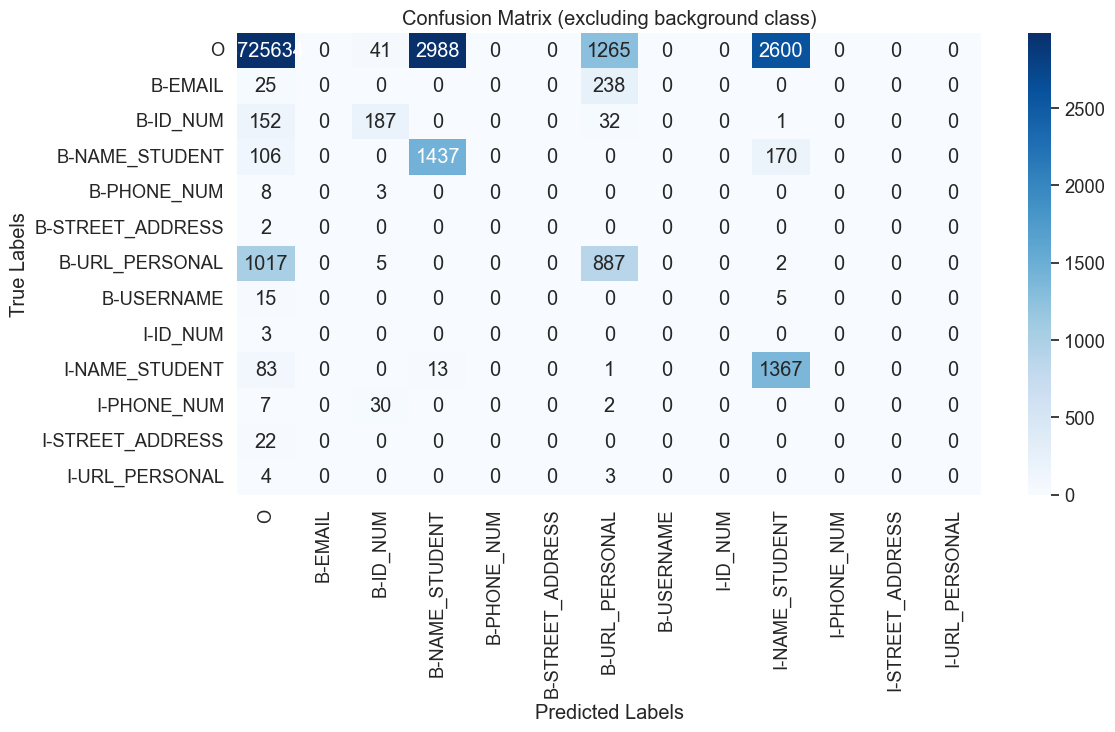

In [29]:
# conf_matrix = np.array([[20, 5, 0],
#                         [3, 25, 2],
#                         [1, 4, 18]])

conf_matrix = confusion_matrix

# Define class labels
# classes = ['Class 1', 'Class 2', 'Class 3']

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

## Word Level

In [34]:
np_entity_id2class_id_b = np.array([class_dict[0] for class_dict  in entity_id2class_id.values()])
np_entity_id2class_id_i = np.array([class_dict[1] for class_dict  in entity_id2class_id.values()])
class_entity_sorted = sorted([(v,k) for k, values in entity_id2class_id.items() for v in values])
class_id2entity_id = {k:v for k,v in  class_entity_sorted}
np_class_id2entity_id = np.array([entity for entity in class_id2entity_id.values()])

In [35]:
%%time
list_pred_words_mapped = [to_bio_vect(pred_words, np_class_id2entity_id) for pred_words in list_pred_words]
flat_word_label_ids = np.concatenate(list_pred_words_mapped)

CPU times: total: 781 ms
Wall time: 826 ms


In [36]:
%%time
list_word_true_labels = preprocessed_dataset['word_labels']

CPU times: total: 10.4 s
Wall time: 11.6 s


In [37]:
%%time
flat_word_true_labels_id = np.array([classes2id[word] for list_words in list_word_true_labels for word in list_words], dtype='int8')

CPU times: total: 828 ms
Wall time: 942 ms


In [38]:
%%time

confusion_matrix_w, TP_w, TN_w, FN_w, FP_w = count_confusion_matrix(predictions = flat_word_label_ids, labels = flat_word_true_labels_id, num_classes = len(classes))

CPU times: total: 125 ms
Wall time: 148 ms


### Vis

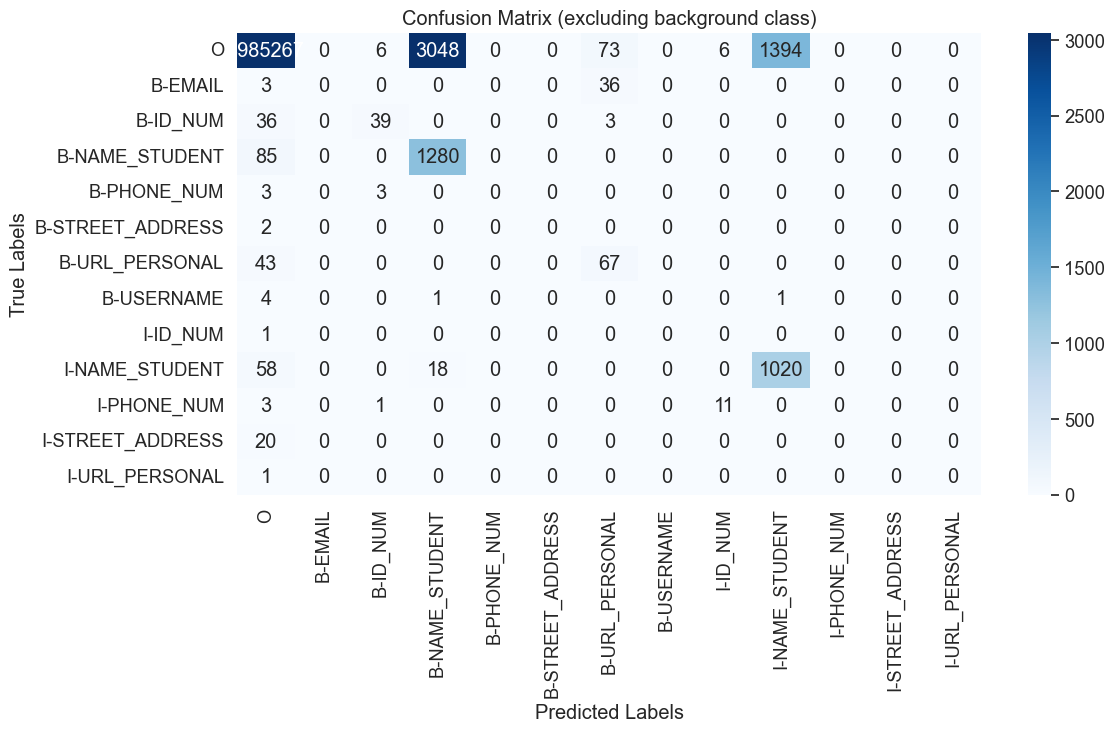

In [39]:
# conf_matrix = np.array([[20, 5, 0],
#                         [3, 25, 2],
#                         [1, 4, 18]])

conf_matrix = confusion_matrix_w

# Define class labels
# classes = ['Class 1', 'Class 2', 'Class 3']

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# To Do

## Compute metrics of V0

## Delta metrics

In [ ]:
#Research delta flat vs percentage
#Research significant delta
#Implement get top significant N results
#Implement summarize remaining results (positive, negative)

## Delta Confusion Matrix

In [ ]:
#Get diff of 2 confusion matrix
## Implement Visualization
# Create colormap Red < =, White == 0, Green > 0
# With normalization

## Record search

Cases we are interested in:
1. records where name_student is present but not identified
  - FN for name_student
  
2. records where PHONE_NUMBER was misidentified as ID_NUM, 
  - FN for PHONE_NUMBER and FP for ID_NUM
3. records where B_Email was misidentified as URL_Personal 


Implement data structure for fast searching:

Approaches: 
1. Per token?
  - Similar performance, a bit difficult to implement
  - Guaranteed since metrics keep track of which token
  - Huge space complexity? 3D: token,metric,label (Token,3) value=label_id
  - How to query:
    - C1: find tokens where FN = NAME_STUDENT, FP = O
    - C2/C3: Find tokens where FN = L1, FP = L2

2. Conf_matrix per record
  - Not guaranteed, condition might match but can be different tokens
  - Fast to implement and execute
  - 






# Bin

## Flat Prefix

In [ ]:
def compute_micro_metrics(predictions, labels, num_classes, pos_labels, prefix='', beta=5):
#     global class_metrics
    
    
    confusion_matrix, TP, TN, FN, FP = count_confusion_matrix(predictions = predictions, labels = labels, num_classes = len(classes))
    
#     class_metrics = {class_label:compute_metrics_per_class(TP, FN, FP, class_label, beta=beta, prefix=prefix) for class_label in range(num_classes)}
    class_metrics = {key:value for class_label in range(num_classes) for key,value in compute_metrics_per_class(TP, FN, FP, class_label, beta=beta, prefix=prefix).items()}
    
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    total_metrics = {f'{prefix}total_precision':total_precision, f'{prefix}total_recall':total_recall, f'{prefix}total_f_beta':total_f_beta,
                     f'{prefix}total_tp':total_tp, f'{prefix}total_fp':total_fp, f'{prefix}total_fn':total_fn}
    
    return total_metrics, class_metrics, confusion_matrix
